#Setup

In [ ]:
!pip install openeo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 5.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Change your directory here
WorkDir = "/content/drive/MyDrive/tensorflow_project/Satellite Image Analysis/"

In [ ]:
import os
os.chdir(WorkDir)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import date
from datetime import datetime
from tqdm import tqdm
import json
import requests
import openeo

##Load Dataset

In [ ]:
location = pd.read_csv('data/water-quality/Final_CUTOFF_noNAN.csv')
location.head()

,DATASET,LAT,LON,DATE,TIME,TEMP,DO,PH,COND
0,coupeville-wharf-mooring,48.222825,-122.688425,2023-02-15,12:00:00,7.2265,11.737,7.73,1.2
1,coupeville-wharf-mooring,48.222825,-122.688425,2023-03-15,13:00:00,8.1186,12.588,8.30,371.4
2,coupeville-wharf-mooring,48.222825,-122.688425,2023-05-10,11:45:00,16.6903,9.373,7.71,169.7
3,coupeville-wharf-mooring,48.222825,-122.688425,2023-05-10,12:00:00,13.5722,10.419,7.38,306.2
4,coupeville-wharf-mooring,48.222825,-122.688425,2023-07-03,10:45:00,16.1236,7.039,8.00,1061.8


In [ ]:
# Change your main responsible dataset here
main_dataset = 'port-susan-buoy'

##Dataset Overview

In [ ]:
location.groupby(['DATASET'])['DATASET'].count()

DATASET
Thai-autostation-dataset    354590
coupeville-wharf-mooring         6
inwatersense-dataset         10993
port-susan-buoy               6092
san-joaquin-delta              468
Name: DATASET, dtype: int64

In [ ]:
#Change Column Name Here : DATE
# print(f'start date : {list(location.DATE)[0]}\nend date : {list(location.DATE)[-1]}')

In [ ]:
#Change Column Name Here : DATE
# date_format = "%Y-%m-%d"

# a = datetime.strptime(list(location.DATE)[0], date_format)
# b = datetime.strptime(list(location.DATE)[-1], date_format)

# delta = b - a

# print(f'Number of days = {delta.days}')

In [ ]:
#Change Column Name Here : LATITUDE AND LONGTITUDE
coor = location[location.DATASET == main_dataset].groupby(['LAT', 'LON']).count().reset_index()

coor

,LAT,LON,DATASET,DATE,TIME,TEMP,DO,PH,COND
0,48.17505,-122.4197,6092,6092,6092,6092,6092,6092,6092


In [ ]:
#Change Column Name Here : LATITUDE AND LONGTITUDE
uniq_coor = []
for i in range(len(coor)):
    uniq_coor.append([coor.iloc[i].LAT, coor.iloc[i].LON])

del coor

uniq_coor

[[48.17505, -122.4197]]

In [ ]:
#Change Column Name Here : LATITUDE AND LONGTITUDE
start_end_date = []

for i in uniq_coor:
    lat_condition = location[location.DATASET == main_dataset]['LAT'] == i[0]
    lon_condition = location[location.DATASET == main_dataset]['LON'] == i[1]

    combined_condition = lat_condition & lon_condition

    filtered_location = location[location.DATASET == main_dataset][combined_condition].sort_values(by='DATE')

    start_date = filtered_location['DATE'].iloc[0]
    end_date = filtered_location['DATE'].iloc[-1]
    start_end_date.append([start_date, end_date])

start_end_date

[['2022-03-01', '2022-10-26']]

In [ ]:
df1 = pd.DataFrame(uniq_coor, columns=["Latitude", "Longitude"])
df2 = pd.DataFrame(start_end_date, columns=["StartDate", "EndDate"])

combined_uniq = pd.concat([df1, df2], axis=1)
combined_uniq

,Latitude,Longitude,StartDate,EndDate
0,48.17505,-122.4197,2022-03-01,2022-10-26


#Access Satellite Images

##Connect to API Data Center

In [ ]:
connection = openeo.connect("openeo.dataspace.copernicus.eu")

###Authentication Needed Here

In [ ]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

###API Overview

In [ ]:
# List collections available on the openEO back-end
connection.list_collection_ids()

['SENTINEL3_OLCI_L1B',
 'SENTINEL3_SLSTR',
 'SENTINEL_5P_L2',
 'SENTINEL2_L1C',
 'SENTINEL2_L2A',
 'SENTINEL1_GRD',
 'COPERNICUS_30']

In [ ]:
# Get detailed metadata of a certain collection
connection.describe_collection("SENTINEL2_L2A")

{'assets': {'thumbnail': {'href': 'https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2022/07/tallinn_estonia/24383281-1-eng-GB/Tallinn_Estonia_pillars.jpg',
   'roles': ['thumbnail'],
   'title': 'Sentinel 2 L2A',
   'type': 'image/png'}},
 'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B01',
    'B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B08',
    'B8A',
    'B09',
    'B11',
    'B12',
    'WVP',
    'AOT',
    'SCL',
    'sunAzimuthAngles',
    'sunZenithAngles',
    'viewAzimuthMean',
    'viewZenithMean']},
  't': {'extent': ['2015-07-04T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-56, 83],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'}},
 'description': 'SENTINEL-2 is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas. The SENTINEL-2 Multispectral Instrument (MSI) samples 13 spectral bands: four bands at 10 metres, six bands at 20 metres and three bands at 60 metres spatial resolution.\n The level 2A data is atmospherically corrected using Sen2Cor.',
 'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
  'temporal': {'interval': [['2015-07-04T00:00:00Z', None]]}},
 'id': 'SENTINEL2_L2A',
 'keywords': ['COPERNICUS',
  'ESA',
  'Orthoimagery',
  'Sentinel-2',
  'MSI',
  'Level-2A',
  'Radiometry',
  'Plant Resource',
  'TOC'],
 'license': 'proprietary',
 'links': [{'href': 'https://sentinels.copernicus.eu/documents/247904/690755/Sentinel_Data_Legal_Notice',
   'rel': 'license',
   'type': 'application/pdf'},
  {'href': 'https://documentation.dataspace.copernicus.eu/Data/Sentinel2.html',
   'rel': 'alternate',
   'type': 'application/html'},
  {'href': 'https://dataspace.copernicus.eu/browser/?zoom=11&lat=45.36638&lng=12.49832&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2F28b654e7-8912-4e59-9e58-85b58d768b3a&datasetId=S2_L2A_CDAS&fromTime=2023-02-07T00%3A00%3A00.000Z&toTime=

#Download & Process Satellite Images

##Filter

Construct Area To Download

In [ ]:
def BuildSquare(lon, lat, delta):
    c1 = [lon + delta, lat + delta]
    c2 = [lon + delta, lat - delta]
    c3 = [lon - delta, lat - delta]
    c4 = [lon - delta, lat + delta]
    geometry = {"type": "Polygon", "coordinates": [[ c1, c2, c3, c4, c1 ]]}
    return geometry

In [ ]:
# range -> 0.0005 = 50 m
delta = 0.0005

In [ ]:
# Create a new column "Polygon" by applying the BuildSquare function to each row
combined_uniq['Polygon'] = combined_uniq.apply(lambda row: BuildSquare(row['Longitude'], row['Latitude'], delta), axis=1)

# Print the updated DataFrame
combined_uniq

,Latitude,Longitude,StartDate,EndDate,Polygon,TextPath
0,48.17505,-122.4197,2022-03-01,2022-10-26,"{'type': 'Polygon', 'coordinates': [[[-122.419...",data/satellite-images/port-susan-buoy/raw0.nc


Select Satellite Project To Download

In [ ]:
Satellite_Proj = "SENTINEL2_L2A"

Max Cloud Coverage

In [ ]:
Max_Cloud_Cover = 50

###Select Bands To Download Here

https://gisgeography.com/sentinel-2-bands-combinations/

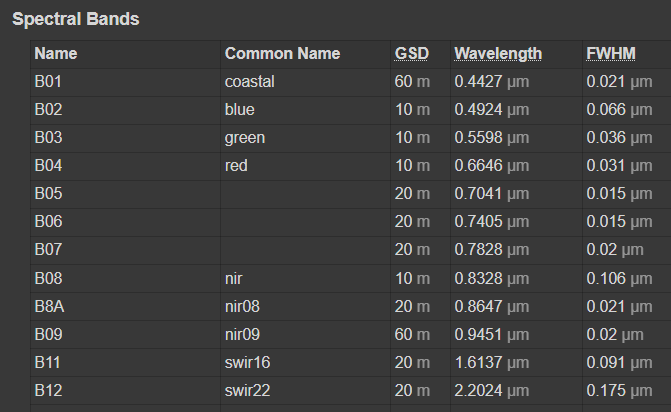

In [ ]:
# Test Band: Try this first!
# Band_To_Download = ["B04", "B03", "B02"]

Band_To_Download = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"]

##Creating Jobs

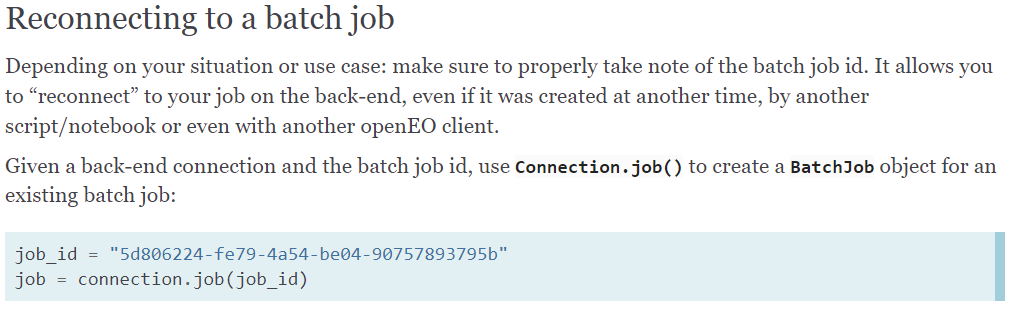

job เอามาใช้เพื่อกันเรื่องของโหลดดาต้าไม่เสร็จระหว่างทาง

สามารถ connect job และ continue การดาวน์โหลดต่อได้

In [ ]:
# DON'T FORGET TO ADD YOUR OWN FOLDER IN GOOGLE DRIVE

combined_uniq['TextPath'] = 'data/satellite-images/' + main_dataset + '/raw' + combined_uniq.index.astype(str) + '.nc'

combined_uniq

,Latitude,Longitude,StartDate,EndDate,Polygon,TextPath
0,48.17505,-122.4197,2022-03-01,2022-10-26,"{'type': 'Polygon', 'coordinates': [[[-122.419...",data/satellite-images/port-susan-buoy/raw0.nc


In [ ]:
# RUN THIS TO MAKE SURE IT SAY 'No data available.' OTHERWISE ASK TONPAI

connection.list_jobs()

[]

In [ ]:
# YOU SHOULDN'T MODIFY THIS UNLESS YOU KNOW WHAT ARE YOU DOING
# CHECK YOUR FOLDER FIRST

jobs = []

for _, row in tqdm(combined_uniq.iterrows()):
    datacube = connection.load_collection(
        Satellite_Proj,
        spatial_extent=row['Polygon'],
        temporal_extent=[row['StartDate'], row['EndDate']],
        bands=Band_To_Download,
        max_cloud_cover=Max_Cloud_Cover
    )

    jobs.append(datacube.create_job(out_format="netCDF", title = row['TextPath']))

0it [00:00, ?it/s]WARNING:openeo.rest.connection:Preflight process graph validation raised: [MissingProduct] Tile 'S2B_MSIL2A_20220306T191249_N0400_R056_T10UEU_20220306T234056' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A_MSIL2A_20220417T185921_N9999_R013_T10UEU_20221219T202836' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A_MSIL2A_20220417T185921_N0400_R013_T10UEU_20220418T000845' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A_MSIL2A_20220520T190921_N9999_R056_T10UEU_20230103T035608' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2B_MSIL2A_20220522T185919_N0400_R013_T10UEU_20220522T215753' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2B_MSIL2A_20220604T190919_N0400_R056_T10UEU_20220604T221641' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2B_MSIL2A_20220621T185919_N0400_R013_T10UEU_20220621T214805' in collection 'SENTINEL2_

## DOWNLOAD

In [ ]:
# THIS SHOULDN'T SAY 'No data available.' AFTER CREATING JOB ABOVE OTHERWISE ASK TONPAI

connection.list_jobs()

[{'created': '2023-11-05T10:56:56Z',
  'id': 'j-231105a0c8c643bf8f189af69f98d4dc',
  'status': 'created',
  'title': 'data/satellite-images/port-susan-buoy/raw0.nc',
  'updated': '2023-11-05T10:56:56Z'}]

In [ ]:
# WILL TAKE A LONG TIME TO DOWNLOAD

for job in tqdm(jobs):
    try:
        job.start_and_wait()
    except:
        print(f'Data Not FOUND -> {job.job_id}')

# WILL TAKE A LONG TIME TO DOWNLOAD

  0%|          | 0/1 [00:00<?, ?it/s]

0:00:00 Job 'j-231105a0c8c643bf8f189af69f98d4dc': send 'start'
0:00:13 Job 'j-231105a0c8c643bf8f189af69f98d4dc': queued (progress N/A)
0:00:18 Job 'j-231105a0c8c643bf8f189af69f98d4dc': queued (progress N/A)
0:00:25 Job 'j-231105a0c8c643bf8f189af69f98d4dc': queued (progress N/A)
0:00:33 Job 'j-231105a0c8c643bf8f189af69f98d4dc': queued (progress N/A)
0:00:43 Job 'j-231105a0c8c643bf8f189af69f98d4dc': queued (progress N/A)
0:00:56 Job 'j-231105a0c8c643bf8f189af69f98d4dc': queued (progress N/A)
0:01:11 Job 'j-231105a0c8c643bf8f189af69f98d4dc': running (progress N/A)
0:01:31 Job 'j-231105a0c8c643bf8f189af69f98d4dc': running (progress N/A)
0:01:55 Job 'j-231105a0c8c643bf8f189af69f98d4dc': running (progress N/A)
0:02:25 Job 'j-231105a0c8c643bf8f189af69f98d4dc': running (progress N/A)


100%|██████████| 1/1 [03:03<00:00, 183.27s/it]

0:03:03 Job 'j-231105a0c8c643bf8f189af69f98d4dc': finished (progress N/A)


In [ ]:
jobs[0].status()

'finished'

In [ ]:
# FOR MANUAL JOB RE-CONNECTING/JOB DELETION

# jobz = connection.job('j-231105b8c04f4b0bb00752eeb536693d')
# jobz = jobz.delete_job()

In [ ]:
# USE THIS IF YOU WANT TO RESTART ALL THE DOWNLOAD
# ASK TONPAI BEFORE DO THIS

# for job in jobs:
#   try:
#       job.delete_job()
#   except:
#       print('Error: Job Not Found or Maybe Already Delete')

#Check If You Can Open the Downloaded File

##Retrive Results

In [ ]:
for job, (_, row)  in zip(jobs, combined_uniq.iterrows()):
    job.get_results().download_file(row['TextPath'])

##Show Results

In [ ]:
import xarray

In [ ]:
ds = xarray.load_dataset(f"data/satellite-images/{main_dataset}/raw0.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[Band_To_Download].to_array(dim="bands")
data.shape

(12, 35, 12, 8)

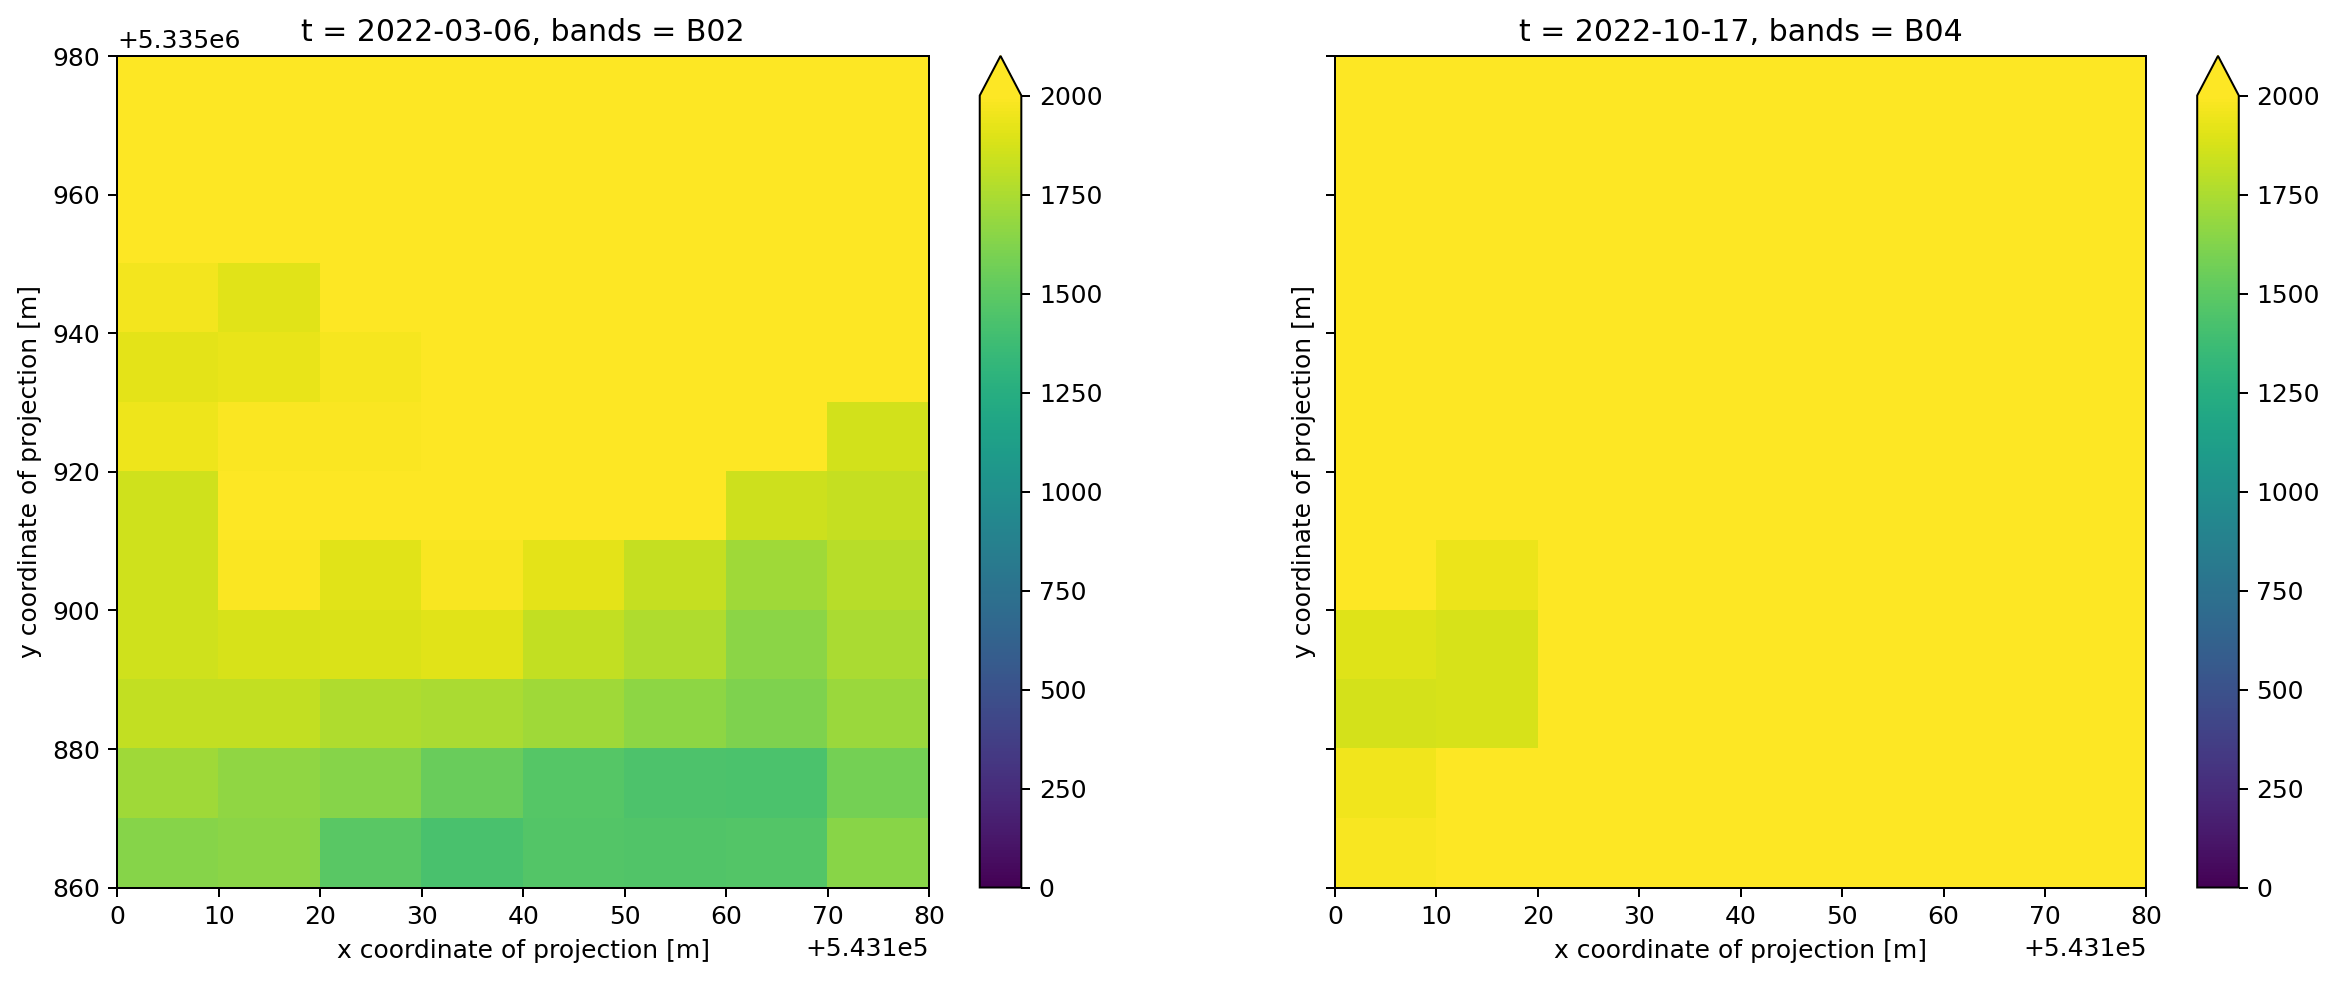

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6), dpi=180, sharey=True)
data[{"t": 0}][1].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
data[{"t": -1}][3].plot.imshow(vmin=0, vmax=2000, ax=axes[1]);